In [ ]:
import os
import random
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import torch
import transformers
import wandb
from datasets import Dataset, load_dataset

# from preprocess import get_chunked_dataframe, preprocess_train
from metrics import f1_df_for_each_threshold
from nltk.tokenize import sent_tokenize, word_tokenize
from pandarallel import pandarallel
from sklearn import metrics
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import MultiLabelBinarizer
from torch import cuda
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertModel,
    BertTokenizer,
    DataCollatorWithPadding,
)

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)


device = "cuda" if cuda.is_available() else "cpu"

In [ ]:
nlp = spacy.load("ru_core_news_lg")
pandarallel.initialize(progress_bar=True)


def split_text_chunks(text, max_words=150, min_words=25):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_word_count = 0

    for sentence in sentences:
        sentence_word_count = len(sentence.split())

        if current_word_count + sentence_word_count > max_words:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
            current_word_count = sentence_word_count
        else:
            current_chunk.append(sentence)
            current_word_count += sentence_word_count

    if current_chunk and current_word_count >= min_words:
        chunks.append(" ".join(current_chunk))

    return chunks if chunks else [text]


def sliding_window_chunks(text, max_words=150, min_words=50):
    sentences = sent_tokenize(text, "russian")
    chunks = []
    current_chunk = []
    start_idx = 0

    while start_idx < len(sentences):
        current_chunk = []
        current_word_count = 0
        for idx in range(start_idx, len(sentences)):
            sentence_word_count = len(sentences[idx].split())

            if current_word_count + sentence_word_count > max_words:
                break
            current_chunk.append(sentences[idx])
            current_word_count += sentence_word_count

        if current_word_count >= min_words:
            chunks.append(" ".join(current_chunk))

        start_idx += 1
    return chunks if chunks else [text]


def get_chunked_dataframe(df):
    df = df.copy()
    chunked_rows = []

    for _, row in df.iterrows():
        if pd.notna(row["text"]):
            text_chunks = split_text_chunks(row["text"])
            for chunk in text_chunks:
                chunked_rows.append([row["movie"], chunk, row["genres"]])
    chunked = pd.DataFrame(chunked_rows, columns=["movie", "text", "genres"])
    chunked["text"].apply(lambda x: len(x.split())).hist(bins=20)

    chunked["text"] = chunked["text"].apply(clear_text)
    return chunked


def clear_text(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\xa0", " ")
    return " ".join(text.split())


def replace_entities(text, nlp):
    doc = nlp(text)
    modified_text = text
    for ent in doc.ents:
        if ent.label_ == "PER":
            modified_text = modified_text.replace(ent.text, "герой")
        elif ent.label_ == "LOC":
            modified_text = modified_text.replace(ent.text, "локация")
    return modified_text


def remove_film_name_from_text(text, film_title):

    film_title_clean = re.sub(r"\(.*?\)", "", film_title).strip()
    text = text.replace(film_title, "фильм")
    text = text.replace(film_title_clean, "фильм")
    return text


def preprocess_train(df: pd.DataFrame):
    df = df.copy()

    df = df.rename(
        {
            "Фильм": "movie",
            "Сюжет": "plot",
            "Жанры": "genres",
            "Описание": "description",
        },
        axis=1,
    )
    print(df.isnull().any())
    df_description = (
        df[["movie", "description", "genres"]]
        .rename(columns={"description": "text"})
        .dropna(subset=["text"])
    )
    df_plot = (
        df[["movie", "plot", "genres"]]
        .rename(columns={"plot": "text"})
        .dropna(subset=["text"])
    )
    df_doubled = pd.concat([df_description, df_plot], ignore_index=True)
    df_doubled["text"] = df_doubled["text"].apply(clear_text)
    df_doubled["text"] = df_doubled["text"].parallel_apply(
        lambda x: replace_entities(x, nlp)
    )
    df_doubled["text"] = df_doubled["text"].apply(clear_text)
    df_doubled["text"] = df_doubled.apply(
        lambda x: remove_film_name_from_text(x["text"], x["movie"]), axis=1
    )
    df_doubled["text"] = df_doubled["text"].apply(clear_text)
    df_doubled["text"].apply(lambda x: len(x.split())).hist(bins=20)
    plt.show()
    return df_doubled

/home/seara/Desktop/Github/mtc-film-classification/.venv/lib/python3.9/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'ru_core_news_lg' (3.7.0) was trained with spaCy v3.7.0 and may not be 100% compatible with the current version (3.8.0). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
df_train = pd.read_csv("data/train_sample.csv")
df_test = pd.read_csv("data/test_sample.csv")

movie          False
description    False
plot            True
genres         False
dtype: bool


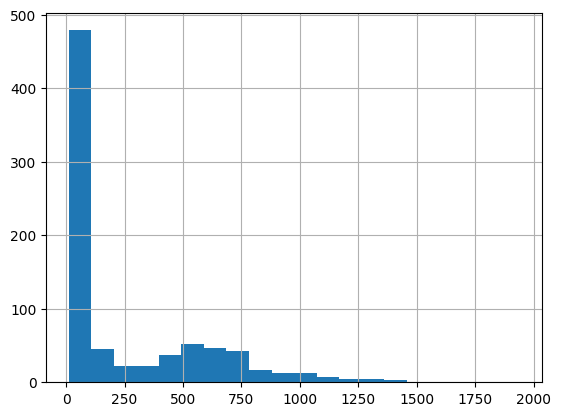

movie          False
description    False
plot            True
genres         False
dtype: bool


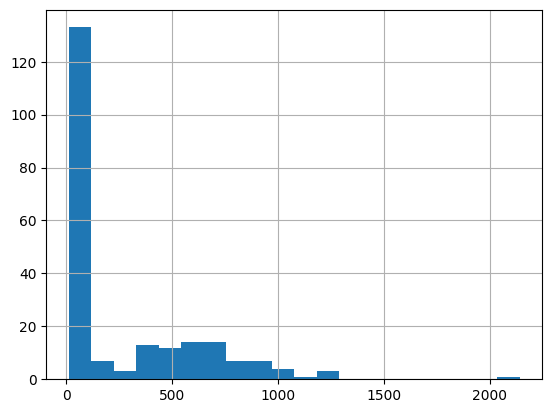

,movie,text,genres
0,Страсти Христовы (2004),Фильм представляет собой драматическое воссозд...,драма
1,Родные (2021),"Однажды вечером отец семейства сообщает, что у...","комедия, драма"
2,Экспресс (2022),герой не унывает даже в трудные времена. После...,"комедия, драма"
3,Братья (2024),"Основанный на реальных событиях, этот фильм по...",драма
4,Гарфилд (2024),"герой (озвучен герой), всемирно известный, нен...","мультфильм, фэнтези, комедия, приключения"
...,...,...,...
808,Человек-паук: Возвращение домой (2017),2012 год. герой и его команда занимаются очист...,"фантастика, боевик, приключения"
809,Я – легенда (2007),Пролог. Доктор герой в телепередаче рассказыва...,"ужасы, фантастика, боевик, триллер, драма"
810,Чужой: Ромул (2024),"Действие происходит в 2180 году, между события...","ужасы, фантастика, триллер"
811,Гарри Поттер и Тайная комната (2002),Во время летних каникул с герой встречает домо...,"фэнтези, приключения"


In [ ]:
df_train = preprocess_train(df_train)
df_test = preprocess_train(df_test)
df_train

,movie,text,genres
0,Страсти Христовы (2004),Фильм представляет собой драматическое воссозд...,драма
1,Родные (2021),"Однажды вечером отец семейства сообщает, что у...","комедия, драма"
2,Экспресс (2022),герой не унывает даже в трудные времена. После...,"комедия, драма"
3,Братья (2024),"Основанный на реальных событиях, этот фильм по...",драма
4,Гарфилд (2024),"герой (озвучен герой), всемирно известный, нен...","мультфильм, фэнтези, комедия, приключения"
...,...,...,...
1971,Гарри Поттер и Тайная комната (2002),Во время матча по квиддичу метивший в герой бл...,"фэнтези, приключения"
1972,Гарри Поттер и Тайная комната (2002),"Однако в этот же вечер к герой приходят герой,...","фэнтези, приключения"
1973,Гарри Поттер и Тайная комната (2002),"Воспользовавшись моментом, герой отбирает у ге...","фэнтези, приключения"
1974,Гарри Поттер и Тайная комната (2002),После сцены в кабинете геройа герой обвиняет Л...,"фэнтези, приключения"


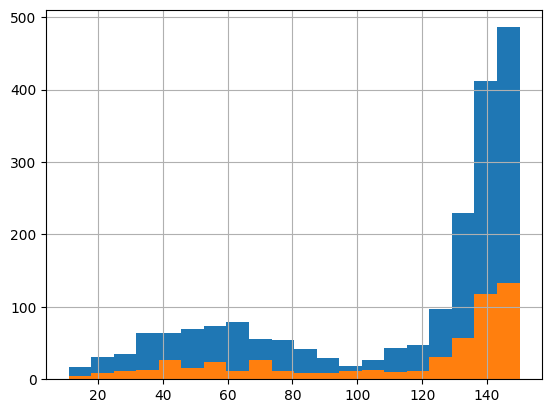

In [ ]:
df_train = get_chunked_dataframe(df_train)
df_test = get_chunked_dataframe(df_test)
df_train

In [ ]:
# from transformers import pipeline

# translator_ru_en = pipeline(
#     "translation", model="Helsinki-NLP/opus-mt-ru-en", device="cuda", batch_size=10
# )
# translator_en_ru = pipeline(
#     "translation", model="Helsinki-NLP/opus-mt-en-ru", device="cuda", batch_size=10
# )


# def translate(text):
#     try:
#         translated_to_en = translator_ru_en(text)
#         back_to_ru = translator_en_ru([x["translation_text"] for x in translated_to_en])

#         return {"translated": [x["translation_text"] for x in back_to_ru]}
#     except Exception as e:
#         print(f"Error during translation: {e}")
#         return text


# dataset_temp = Dataset.from_pandas(df_train)

# dataset_temp = dataset_temp.map(lambda x: translate(x["text"]), batched=True, batch_size=10)
# temp_df = dataset_temp.to_pandas()

In [ ]:
# temp_df = pd.read_csv("data/translated_df_train.csv")

# temp_df = temp_df.drop("text", axis=1)
# temp_df = temp_df.rename(columns={"translated": "text"})
# df_train = pd.concat([df_train, temp_df], ignore_index=True)

In [ ]:
df_train["genres"] = df_train["genres"].apply(lambda x: x.split(", "))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_train["genres"])
df_train["target"] = y.tolist()
df_train = df_train.drop("genres", axis=1)

df_test["genres"] = df_test["genres"].apply(lambda x: x.split(", "))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_test["genres"])
df_test["target"] = y.tolist()
df_test = df_test.drop("genres", axis=1)

df_train

,movie,text,target
0,Страсти Христовы (2004),Фильм представляет собой драматическое воссозд...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,Родные (2021),"Однажды вечером отец семейства сообщает, что у...","[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Экспресс (2022),герой не унывает даже в трудные времена. После...,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Братья (2024),"Основанный на реальных событиях, этот фильм по...","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Гарфилд (2024),"герой (озвучен герой), всемирно известный, нен...","[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]"
...,...,...,...
1971,Гарри Поттер и Тайная комната (2002),Во время матча по квиддичу метивший в герой бл...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1972,Гарри Поттер и Тайная комната (2002),"Однако в этот же вечер к герой приходят герой,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1973,Гарри Поттер и Тайная комната (2002),"Воспользовавшись моментом, герой отбирает у ге...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"
1974,Гарри Поттер и Тайная комната (2002),После сцены в кабинете геройа герой обвиняет Л...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]"


In [ ]:
max_length = 256
num_labels = len(mlb.classes_)
label2id = dict(zip(mlb.classes_, range(num_labels)))
id2label = dict(zip(range(num_labels), mlb.classes_))
model = "ai-forever/ruBert-base"
# model = "ai-forever/ruRoberta-large"
# model = "cointegrated/rubert-tiny2"
problem_type = "multi_label_classification"
batch_size = 2
pin_memory = False
drop_last = False
num_workers = 4
shuffle = True
# val_size = int(len(df) * 0.2)
num_epochs = 4


os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model)

model = BertForSequenceClassification.from_pretrained(
    model,
    num_labels=num_labels,
    problem_type=problem_type,
    label2id=label2id,
    id2label=id2label,
)

/home/seara/Desktop/Github/mtc-film-classification/.venv/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


(array([ 99., 208., 203., 106., 100., 472., 723.,  62.,   2.,   1.]),
 array([ 19. ,  48.1,  77.2, 106.3, 135.4, 164.5, 193.6, 222.7, 251.8,
        280.9, 310. ]),
 <BarContainer object of 10 artists>)

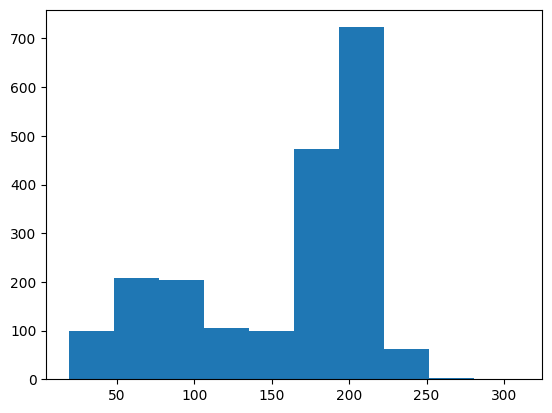

In [ ]:
plt.hist(list(map(len, tokenizer(df_train["text"].tolist())["input_ids"])))

In [ ]:
dataset_train = Dataset.from_pandas(df_train)
dataset_train = dataset_train.map(
    lambda x: tokenizer(x["text"], truncation=True, max_length=max_length),
    batched=True,
)
dataset_train = dataset_train.map(
    lambda x: {"label": [float(y) for y in x["target"]]},
    batched=False,
    remove_columns=["text", "target"],
)


dataset_test = Dataset.from_pandas(df_test)
dataset_test = dataset_test.map(
    lambda x: tokenizer(x["text"], truncation=True, max_length=max_length),
    batched=True,
)
dataset_test = dataset_test.map(
    lambda x: {"label": [float(y) for y in x["target"]]},
    batched=False,
    remove_columns=["text", "target"],
)

Map:   0%|          | 0/1976 [00:00<?, ? examples/s]

Map:   0%|          | 0/1976 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

Map:   0%|          | 0/553 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)
# train_val = dataset.train_test_split(test_size=val_size)
train_wo_movie = dataset_train.remove_columns(["movie"])
test_wo_movie = dataset_test.remove_columns(["movie"])

train_dataloader = DataLoader(
    train_wo_movie,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
    collate_fn=data_collator,
    pin_memory=pin_memory,
    drop_last=drop_last,
)

val_dataloader = DataLoader(
    test_wo_movie,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=data_collator,
    pin_memory=pin_memory,
    drop_last=drop_last,
)

In [ ]:
def predict(model, dataloader):
    with torch.inference_mode():
        y_true = []
        y_pred = []
        val_loss = 0

        for batch in tqdm(dataloader):
            batch = batch.to(model.device)
            output = model(**batch)
            loss = output.loss

            val_loss += loss.item() * batch["input_ids"].size(0)
            y_true.append(batch.labels.cpu())
            y_pred.append(output.logits.cpu())

        val_loss = val_loss / len(dataloader.dataset)

    return (
        torch.cat(y_true).numpy(),
        torch.sigmoid(torch.cat(y_pred)).numpy(),
        val_loss,
    )


def train_epoch(model, train_dataloader, optimizer):
    y_true = []
    y_pred = []
    train_loss = 0

    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        batch = batch.to(model.device)
        output = model(**batch)
        loss = output.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch["input_ids"].size(0)
        y_true.append(batch.labels.detach().cpu())
        y_pred.append(output.logits.detach().cpu())

    train_loss = train_loss / len(train_dataloader.dataset)
    return (
        torch.cat(y_true).numpy(),
        torch.sigmoid(torch.cat(y_pred)).numpy(),
        train_loss,
    )


def eval(model, val_dataloader, labels, dataset):
    model.eval()
    val_y_true, val_y_pred, val_loss = predict(model, val_dataloader)

    df_eval = dataset.to_pandas()
    df_eval = df_eval.drop(["input_ids", "attention_mask", "token_type_ids"], axis=1)

    df_eval["eval"] = val_y_pred.tolist()
    gb = (
        df_eval.groupby("movie")
        .agg({"eval": lambda x: [sum(i) / len(i) for i in zip(*x)], "label": "first"})
        .reset_index()
    )

    report_dict = f1_df_for_each_threshold(
        np.array(gb["label"].to_list()), np.array(gb["eval"].to_list()), num_labels
    )

    df = pd.DataFrame(report_dict)
    df = df.round(2).T
    df.columns = [*labels, "macro"]
    return df, val_y_true, val_y_pred, val_loss

In [ ]:
def train(model, train_dataloader, optimizer, epochs, val_dataloader, labels, dataset):
    tq = tqdm(range(epochs))

    for epoch in tq:

        model.train()
        train_y_true, train_y_pred, train_loss = train_epoch(
            model, train_dataloader, optimizer
        )

        model.eval()

        df, val_y_true, val_y_pred, val_loss = eval(
            model, val_dataloader, labels, dataset
        )

        wandb.log(
            {
                "train_loss": train_loss,
                "val_loss": val_loss,
                "f10.5": df["macro"].loc[0.5],
                "f10.3": df["macro"].loc[0.3],
                "f10.4": df["macro"].loc[0.4],
            }
        )

        tq.set_description(f"train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    df, val_y_true, val_y_pred, val_loss = eval(model, val_dataloader, labels, dataset)

    display(df)

    return val_y_true, val_y_pred

In [ ]:
torch.cuda.empty_cache()
model.cuda()

optimizer = Adam(model.parameters(), lr=0.00001)
wandb.init("mtc-nlp")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: seara. Use `wandb login --relogin` to force relogin


In [ ]:
val_y_true, val_y_pred = train(
    model=model,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=num_epochs,
    val_dataloader=val_dataloader,
    labels=id2label.values(),
    dataset=dataset_test,
)
wandb.finish()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/988 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/988 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/988 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/988 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

  0%|          | 0/277 [00:00<?, ?it/s]

,боевик,детектив,драма,история,комедия,криминал,мелодрама,мультфильм,мюзикл,приключения,триллер,ужасы,фантастика,фэнтези,macro
0.0,0.45,0.21,0.67,0.24,0.50,0.40,0.20,0.21,0.08,0.34,0.45,0.15,0.32,0.24,0.32
0.1,0.57,0.35,0.68,0.54,0.55,0.64,0.40,0.50,0.00,0.66,0.60,0.47,0.69,0.51,0.51
0.2,0.65,0.42,0.72,0.38,0.58,0.69,0.53,0.55,0.00,0.62,0.65,0.67,0.81,0.63,0.57
0.3,0.70,0.27,0.75,0.35,0.60,0.68,0.52,0.42,0.00,0.58,0.64,0.56,0.82,0.58,0.53
0.4,0.76,0.30,0.72,0.36,0.58,0.70,0.38,0.33,0.00,0.61,0.59,0.62,0.79,0.57,0.52
0.5,0.76,0.22,0.70,0.36,0.52,0.70,0.32,0.24,0.00,0.56,0.55,0.62,0.76,0.59,0.49
0.6,0.76,0.13,0.67,0.38,0.39,0.73,0.24,0.13,0.00,0.49,0.38,0.53,0.73,0.54,0.44
0.7,0.79,0.13,0.59,0.38,0.28,0.78,0.13,0.00,0.00,0.46,0.27,0.46,0.67,0.48,0.39
0.8,0.69,0.00,0.46,0.22,0.18,0.71,0.13,0.00,0.00,0.35,0.21,0.46,0.59,0.42,0.32
0.9,0.43,0.00,0.26,0.12,0.10,0.41,0.00,0.00,0.00,0.21,0.06,0.00,0.47,0.40,0.18


f10.3,▁▆█▇
f10.4,▁▄██
f10.5,▁▅▇█
train_loss,█▅▃▁
val_loss,▇▁▄█
f10.3,0.53
f10.4,0.52
f10.5,0.49
train_loss,0.17473
val_loss,0.39479


In [ ]:
model.cpu()

model.save_pretrained("models/62-43", safe_serialization=False)
tokenizer.save_pretrained("models/62-43")
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
submission = pd.read_csv("data/public_test.csv")
submission["Жанры"] = "empty"

movie          False
description    False
plot            True
genres         False
dtype: bool


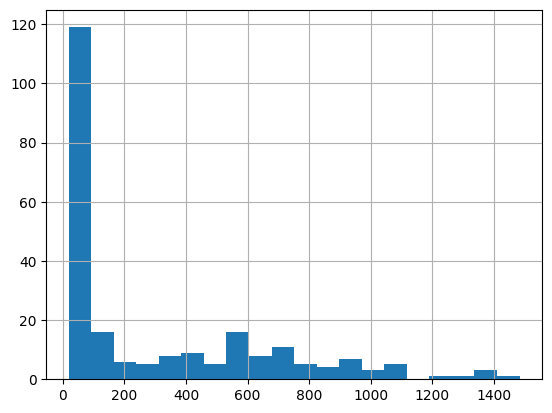

,movie,text,genres
0,Убойные каникулы (2010),Двое простых деревенских парней герой и локаци...,empty
1,"Три билборда на границе Эббинга, Миссури (2017)",После того как убийцы её дочери не были найден...,empty
2,Глубоководный горизонт (2016),История о катастрофе на нефтяной платформе «фи...,empty
3,Главный герой (2021),Парень живет в идеальном для себя мире — в луч...,empty
4,Мистер и миссис Смит (2005),"герой и герой, уставшие от однообразия брака, ...",empty
...,...,...,...
228,Белая птица: Новое чудо (2023),После событий «Чуда» герой навсегда покинул ге...,empty
229,Манюня: Приключения в Москве (2024),Девочки вместе с герой едут на поезде в локаци...,empty
230,Мадагаскар (2005),В зоопарке локация зебра герой празднует десят...,empty
231,Взаперти (2020),Женщина по имени герой преждевременно рожает д...,empty


In [ ]:
submission = preprocess_train(submission)
submission

,movie,text,genres
0,Убойные каникулы (2010),Двое простых деревенских парней герой и локаци...,empty
1,"Три билборда на границе Эббинга, Миссури (2017)",После того как убийцы её дочери не были найден...,empty
2,Глубоководный горизонт (2016),История о катастрофе на нефтяной платформе «фи...,empty
3,Главный герой (2021),Парень живет в идеальном для себя мире — в луч...,empty
4,Мистер и миссис Смит (2005),"герой и герой, уставшие от однообразия брака, ...",empty
...,...,...,...
624,Взаперти (2020),"Понимая, что герой не даст ей умереть, герой п...",empty
625,Взаперти (2020),В палате герой рассказывает кому-то о своём му...,empty
626,Добро пожаловать в Zомбилэнд (2009),"После того, как локация подверглась зомби-апок...",empty
627,Добро пожаловать в Zомбилэнд (2009),"Девушки обманом забирают у них автомобиль, что...",empty


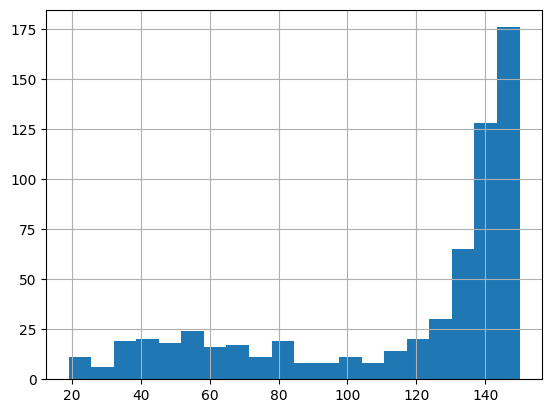

In [ ]:
submission = get_chunked_dataframe(submission)
submission

In [ ]:
dataset = Dataset.from_pandas(submission[["text"]])
dataset = dataset.map(
    lambda x: tokenizer(x["text"], truncation=True, max_length=max_length),
    batched=True,
    remove_columns=["text"],
)
test_dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=data_collator,
    pin_memory=pin_memory,
    drop_last=drop_last,
)


def test(model, dataloader):
    with torch.inference_mode():
        y_pred = []

        for batch in tqdm(dataloader):
            batch = batch.to(model.device)
            output = model(**batch)

            y_pred.append(output.logits.cpu())

    return torch.sigmoid(torch.cat(y_pred)).numpy()


prediction = test(model, test_dataloader)

Map:   0%|          | 0/629 [00:00<?, ? examples/s]

  0%|          | 0/315 [00:00<?, ?it/s]

In [ ]:
submission["genres"] = prediction.tolist()
submission

,movie,text,genres
0,Убойные каникулы (2010),Двое простых деревенских парней герой и локаци...,"[0.04949697479605675, 0.020137710496783257, 0...."
1,"Три билборда на границе Эббинга, Миссури (2017)",После того как убийцы её дочери не были найден...,"[0.17003187537193298, 0.3718854784965515, 0.92..."
2,Глубоководный горизонт (2016),История о катастрофе на нефтяной платформе «фи...,"[0.18724659085273743, 0.13813519477844238, 0.8..."
3,Главный герой (2021),Парень живет в идеальном для себя мире — в луч...,"[0.6282039880752563, 0.05028577521443367, 0.11..."
4,Мистер и миссис Смит (2005),"герой и герой, уставшие от однообразия брака, ...","[0.18474183976650238, 0.045453477650880814, 0...."
...,...,...,...
624,Взаперти (2020),"Понимая, что герой не даст ей умереть, герой п...","[0.05596473067998886, 0.26611554622650146, 0.7..."
625,Взаперти (2020),В палате герой рассказывает кому-то о своём му...,"[0.043554022908210754, 0.4377816915512085, 0.9..."
626,Добро пожаловать в Zомбилэнд (2009),"После того, как локация подверглась зомби-апок...","[0.9531940221786499, 0.034512344747781754, 0.1..."
627,Добро пожаловать в Zомбилэнд (2009),"Девушки обманом забирают у них автомобиль, что...","[0.3454977571964264, 0.027785954996943474, 0.0..."


In [ ]:
submission = (
    submission.groupby("movie")["genres"]
    .agg(lambda x: [sum(i) / len(i) for i in zip(*x)])
    .reset_index()
)

# submission = (
#     submission.groupby("movie")
#     .agg({"genres": "first"})
#     .reset_index()
# )


# submission["text_length"] = submission["text"].apply(len)

# # Now, calculate the weighted sum of the genres probabilities
# def weighted_sum(genres, weights):
#     # Normalize weights
#     normalized_weights = [w / sum(weights) for w in weights]
#     # Compute the weighted sum of each genre probability
#     return [sum(g * w for g, w in zip(genre_probs, normalized_weights)) for genre_probs in zip(*genres)]

# # Apply the new aggregation with weights
# submission = (
#     submission.groupby("movie").apply(lambda group: pd.Series({
#         "genres": weighted_sum(group["genres"], group["text_length"])
#     })).reset_index()
# )


submission.columns = ["Фильм", "Жанры"]
submission

,Фильм,Жанры
0,127 часов (2010),"[0.3345620557665825, 0.11165895313024521, 0.74..."
1,1408 (2007),"[0.06009996775537729, 0.21581990271806717, 0.2..."
2,365 дней (2020),"[0.6580522954463959, 0.033706676214933395, 0.0..."
3,500 дней лета (2009),"[0.04459287412464619, 0.030639370903372765, 0...."
4,57 секунд (2023),"[0.7215941548347473, 0.2002185583114624, 0.034..."
...,...,...
117,Шестое чувство (1999),"[0.11909177961448829, 0.4633779115974903, 0.50..."
118,Шрэк (2001),"[0.11149512231349945, 0.046524977311491966, 0...."
119,Эбигейл (2024),"[0.9785304665565491, 0.06800107657909393, 0.06..."
120,Эквилибриум (2002),"[0.5024874359369278, 0.3100803541019559, 0.827..."


In [ ]:
# threshold = 0.3

threshold = [0.7, 0.3, 0.25, 0.05, 0.35, 0.7, 0.2, 0.2, 0.01, 0.3, 0.4, 0.4, 0.35, 0.2]
predicted_labels = []
for pred_ in submission["Жанры"].to_list():
    pred = (np.array(pred_) >= threshold).astype(int)
    labels = [id2label[idx] for idx, value in enumerate(pred) if value == 1]
    if not labels:
        labels = [id2label[np.argmax(pred)]]
    predicted_labels.append(labels)

In [ ]:
submission["Жанры"] = predicted_labels
submission["Жанры"] = submission["Жанры"].apply(lambda x: ", ".join(x))
submission.set_index("Фильм").loc[
    pd.read_csv("data/sample_submission_seed_0.csv")["Фильм"]
].to_csv("submission.csv")